# Setup

In [38]:
%load_ext autoreload
%autoreload 2
%aimport

%matplotlib inline 

import torch
import matplotlib.pyplot as plt
from einops import rearrange

from bliss.catalog import TileCatalog, get_images_in_tiles
from bliss.encoder import Encoder


device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:

5


# Load models

In [2]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate

with initialize(config_path="../../coadds/config"):
    cfg = compose("config", overrides=[])

In [11]:
weights_file

'/home/wmallory/bliss/case_studies/coadds/output'

In [4]:
location = instantiate(cfg.models.detection_encoder).to(device).eval()
# NOTE: change weight_checkpoint to the one in your output folder
location.load_state_dict(torch.load('../../coadds/models/encoder_1.pt', map_location=location.device)
)

encoder = Encoder(location.eval(), n_images_per_batch=10, n_rows_per_batch=15).to(device)

In [5]:
location_coadd = instantiate(cfg.models.detection_encoder).to(device).eval()
location.load_state_dict(torch.load('../../coadds/models/coadd_encoder_1.pt', map_location=location.device)
)

encoder_coadd = Encoder(location.eval(), n_images_per_batch=10, n_rows_per_batch=15).to(device)

In [6]:
location_coadd = instantiate(cfg.models.detection_encoder).to(device).eval()
location.load_state_dict(torch.load('../../coadds/models/coadd_encoder_2.pt', map_location=location.device)
)

encoder_coadd_25 = Encoder(location.eval(), n_images_per_batch=10, n_rows_per_batch=15).to(device)

# Load datasets

## Coadd dataset with N_dithers = 10

In [57]:
with initialize(config_path="../config"):
    cfg = compose("config", overrides=[])

In [58]:
# should be ONLY stars
cfg.datasets.galsim_blends_coadds.prior.galaxy_prob

0.0

In [59]:
cfg.datasets.galsim_blends_coadds.prior.n_dithers = 10

In [18]:
ds = instantiate(cfg.datasets.galsim_blends_coadds, batch_size=64, n_batches=100, num_workers=20)

In [19]:
from bliss.generate import generate
generate(ds, '../output/coadd_dataset.pt', '../output/coadd_dataset.png', 9, global_params=("background",))


Generating dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.75it/s]


# Run model on saved dataset

In [20]:
sds = torch.load('../output/coadd_dataset.pt')
sds['images'].shape, sds['noisy'].shape, sds['n_sources'].shape

(torch.Size([6400, 1, 88, 88]),
 torch.Size([6400, 1, 88, 88]),
 torch.Size([6400, 10, 10]))

In [27]:
# keys of dataset
sds.keys()

dict_keys(['images', 'noisy', 'background', 'n_sources', 'locs', 'galaxy_bools', 'star_bools', 'galaxy_params', 'star_fluxes', 'star_log_fluxes'])

In [28]:
# parameters saved are on tiles
sds['locs'].shape

torch.Size([6400, 10, 10, 1, 2])

In [23]:
# format background (needs to be CONSTANT)
n_batches = sds['images'].shape[0]
slen = sds['images'].shape[-1]
background = rearrange(sds['background'], '1 h w -> 1 1 h w')
background = background.expand(n_batches, 1, slen, slen)

In [24]:
# run (single-exposure) model prediction 
tile_est = encoder.variational_mode(sds['noisy'], background)

Encoding ptiles: 640it [00:20, 30.76it/s]


In [34]:
# run (coadd) model prediction 
tile_est_coadd = encoder_coadd.variational_mode(sds['noisy'], background)

Encoding ptiles: 128it [00:04, 30.24it/s]


In [52]:
# run (coadd) model prediction 
tile_est_coadd_25 = encoder_coadd_25.variational_mode(sds['noisy'], background)

Encoding ptiles: 128it [00:04, 30.74it/s]


In [67]:
sds['star_bools'][12].squeeze()

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

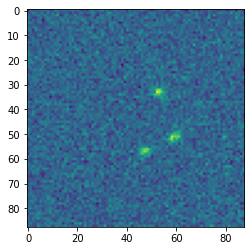

In [55]:
plt.imshow(sds['noisy'][12,0].numpy())

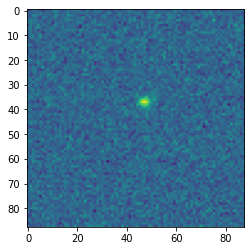

In [78]:
plt.imshow(sds['images'][30,0].numpy())

# Metrics on prediction compared to truth

In [29]:
catalog_dict = {
    "locs": sds["locs"],
    "star_log_fluxes": sds["star_log_fluxes"],
    "galaxy_bools": sds["galaxy_bools"],
    "n_sources": sds["n_sources"],
    "star_fluxes": sds['star_fluxes']
}

In [32]:
true_tile_catalog = TileCatalog(4, catalog_dict)
truth = true_tile_catalog.to_full_params()

In [36]:
truth['star_bools']

tensor([[[1.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.]],

        [[1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.]],

        ...,

        [[1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[1.],
         [1.],
         [1.],
         [1.],
         [0.],
         [0.]],

        [[1.],
         [1.],
         [1.],
         [1.],
         [0.],
         [0.]]])

## Get Full Catalogs

In [30]:
est = tile_est.cpu().to_full_params() # full estimated catalog from single exposure model

In [31]:
# parameters are now per image
est.plocs.shape

torch.Size([6400, 14, 2])

## Simple metrics

In [33]:
from bliss.reporting import DetectionMetrics
metrics = DetectionMetrics()(truth, est)
metrics['f1']

tensor(0.5709)

In [34]:
print(truth.n_sources)
print(est.n_sources)

tensor([3, 1, 5,  ..., 2, 4, 4])
tensor([3, 6, 9,  ..., 5, 7, 7])


## Get magnitude buckets

In [63]:
# NOTE: add 'mag' to catalog
from bliss.datasets.sdss import convert_flux_to_mag
est['mags'] = convert_flux_to_mag(est['star_fluxes'])

In [74]:
shape = truth['star_fluxes'].shape
tags = np.zeros(shape, dtype=int)
for i in range(shape[0]): 
    for j in range(shape[1]):
        tags[i, j, :] = int(i)
tags = torch.from_numpy(tags)

In [56]:
truth['star_fluxes'].shape

torch.Size([10240, 6, 1])

In [80]:
truth['star_log_fluxes'][6]

tensor([[ 7.7073],
        [10.1148],
        [ 6.4790],
        [ 6.7290],
        [ 8.0596],
        [ 0.0000]])

In [47]:
keep = truth['star_log_fluxes'] > 10
keep.shape

torch.Size([10240, 6, 1])

In [48]:
from einops import rearrange
keep = rearrange(keep, "n s 1 -> n s")
keep.shape

torch.Size([10240, 6])

In [49]:
d = {k: v[keep].unsqueeze(0) for k, v in truth.items()}
d['plocs'] = plocs

In [81]:
d['star_fluxes'].squeeze()

tensor([ 23241.5762,  24705.8379,  56865.2266,  ...,  31254.4883,
        473698.2812, 207236.9531])

In [77]:
_tags = tags[keep].squeeze()
_tags.shape

tensor([    0,     6,     9,  ..., 10236, 10238, 10239])

In [119]:
_tags

tensor([    0,     6,     9,  ..., 10236, 10238, 10239])

In [120]:
for ii, t in enumerate(_tags):
    print(t)

tensor(0)
tensor(6)
tensor(9)
tensor(13)
tensor(17)
tensor(17)
tensor(18)
tensor(19)
tensor(19)
tensor(22)
tensor(23)
tensor(23)
tensor(23)
tensor(27)
tensor(27)
tensor(28)
tensor(29)
tensor(30)
tensor(30)
tensor(31)
tensor(33)
tensor(37)
tensor(40)
tensor(41)
tensor(41)
tensor(41)
tensor(42)
tensor(43)
tensor(47)
tensor(48)
tensor(49)
tensor(49)
tensor(52)
tensor(54)
tensor(55)
tensor(56)
tensor(60)
tensor(61)
tensor(63)
tensor(63)
tensor(65)
tensor(66)
tensor(67)
tensor(69)
tensor(69)
tensor(73)
tensor(73)
tensor(75)
tensor(76)
tensor(77)
tensor(77)
tensor(78)
tensor(80)
tensor(81)
tensor(82)
tensor(86)
tensor(86)
tensor(87)
tensor(88)
tensor(88)
tensor(89)
tensor(90)
tensor(91)
tensor(94)
tensor(97)
tensor(100)
tensor(101)
tensor(101)
tensor(102)
tensor(105)
tensor(105)
tensor(107)
tensor(108)
tensor(108)
tensor(111)
tensor(113)
tensor(114)
tensor(117)
tensor(117)
tensor(118)
tensor(120)
tensor(120)
tensor(124)
tensor(126)
tensor(129)
tensor(135)
tensor(137)
tensor(141)
tensor(145)


tensor(7962)
tensor(7964)
tensor(7964)
tensor(7967)
tensor(7971)
tensor(7972)
tensor(7974)
tensor(7975)
tensor(7976)
tensor(7978)
tensor(7979)
tensor(7985)
tensor(7987)
tensor(7990)
tensor(7991)
tensor(7996)
tensor(7996)
tensor(7998)
tensor(8000)
tensor(8000)
tensor(8001)
tensor(8004)
tensor(8006)
tensor(8006)
tensor(8010)
tensor(8012)
tensor(8015)
tensor(8016)
tensor(8017)
tensor(8017)
tensor(8021)
tensor(8025)
tensor(8026)
tensor(8030)
tensor(8031)
tensor(8033)
tensor(8035)
tensor(8037)
tensor(8038)
tensor(8039)
tensor(8041)
tensor(8043)
tensor(8048)
tensor(8049)
tensor(8051)
tensor(8051)
tensor(8052)
tensor(8054)
tensor(8055)
tensor(8057)
tensor(8057)
tensor(8059)
tensor(8061)
tensor(8063)
tensor(8063)
tensor(8068)
tensor(8070)
tensor(8074)
tensor(8076)
tensor(8079)
tensor(8080)
tensor(8083)
tensor(8088)
tensor(8089)
tensor(8089)
tensor(8091)
tensor(8091)
tensor(8092)
tensor(8094)
tensor(8094)
tensor(8096)
tensor(8097)
tensor(8100)
tensor(8102)
tensor(8102)
tensor(8106)
tensor(8114)

In [121]:
from collections import defaultdict
new_d = {}
for k,v in d.items():
    counts_t = defaultdict(int)
    new_v = torch.zeros(truth[k].shape)
    for ii, t in enumerate(_tags):
        t = t.item()
        new_v[t,counts_t[t]] = v.squeeze()[ii]
        counts_t[t] += 1
    new_d[k] = new_v

0
1
2


In [117]:
counts_t = defaultdict(int)
print(counts_t['a'])
counts_t['a'] +=1 
print(counts_t['b'])
print(counts_t['a'])

0
0
1


In [102]:
_tags_np = _tags.numpy()
uniq, counts = np.unique(_tags_np, return_counts=True)

In [107]:
_tags[-5:]

tensor([10236, 10236, 10236, 10238, 10239])

In [111]:
d['star_fluxes'].squeeze()[-5:]

tensor([119459.2578, 492941.7500,  31254.4883, 473698.2812, 207236.9531])

In [134]:
n_sources = keep.sum(axis=-1)

In [131]:
new_d['star_bools']

tensor([[[1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]])

In [122]:
new_d['star_fluxes'][10236]

tensor([[119459.2578],
        [492941.7500],
        [ 31254.4883],
        [     0.0000],
        [     0.0000],
        [     0.0000]])

In [53]:
d['star_fluxes'].squeeze()

tensor([ 23241.5762,  24705.8379,  56865.2266,  ...,  31254.4883,
        473698.2812, 207236.9531])

In [83]:
from collections import defaultdict

counts_t = defaultdict(int)

In [85]:
counts_t['a'] += 1

In [86]:
counts_t['a']

1

In [29]:
d = {k: v for k, v in truth.items()}


In [33]:
d['star_log_fluxes']

torch.Size([10240, 6, 1])

tensor(0.9329)

In [27]:
from bliss.datasets.sdss import convert_flux_to_mag
star_mags = convert_flux_to_mag(truth['star_fluxes'])
star_mags[star_mags==np.inf] = 0
star_mags

tensor([[[19.0705],
         [22.6463],
         [21.3422],
         [22.2684],
         [22.7750],
         [22.5623]],

        [[22.3324],
         [21.1782],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]],

        [[21.7743],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]],

        ...,

        [[21.9050],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]],

        [[20.8217],
         [20.2159],
         [15.7974],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]],

        [[19.7890],
         [20.3525],
         [16.6950],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]]])